### Import Modules

In [50]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from skimage import color, exposure
import time
from sklearn import svm
from sklearn.model_selection import train_test_split, GridSearchCV, ParameterGrid
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import accuracy_score

# So we can see the output of multiple variables in a single cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### Functions

In [366]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block,
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  transform_sqrt=True,
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:
        features = hog(img, orientations=orient,
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       transform_sqrt=True,
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel()
    # Return the feature vector
    return features

# Define a function to compute color histogram features
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                     hist_bins=32, orient=9,
                     pix_per_cell=8, cell_per_block=2, hog_channel=0,
                     spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel],
                                        orient, pix_per_cell, cell_per_block,
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient,
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

# Define a function that takes an image,
# start and stop positions in both x and y,
# window size (x and y dimensions),
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None],
                 xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step)
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step)
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]

            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows corner vertices 
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
        
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
        else:
            hog_features, hog_image = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=True, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features), hog_image

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

# the following function is from the project QnA
# define a funciton for plotting multiple images
def visualize(fig, rows, cols, imgs, titles):
    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i+1)
        plt.axis('off')
        plt.title(i+1)
        img_dims = len(img.shape)
        if img_dims < 3:
            plt.imshow(img, cmap='hot')
            plt.title(titles[i])
        else:
            plt.imshow(img)
            plt.title(titles[i])

### Create a list of image

In [232]:
# images are divided up into vehicles and non-vehicles
cars = glob.glob(r'D:\SDC\p5-vehicle-detection\small-vehicles\vehicles-smallset/**/*.jpeg')
notcars = glob.glob(r'D:\SDC\p5-vehicle-detection\small-non-vehicles\non-vehicles-smallset\**\*.jpeg')
len(cars)
len(notcars)

1196

1125

### Explore Color Space

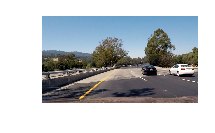

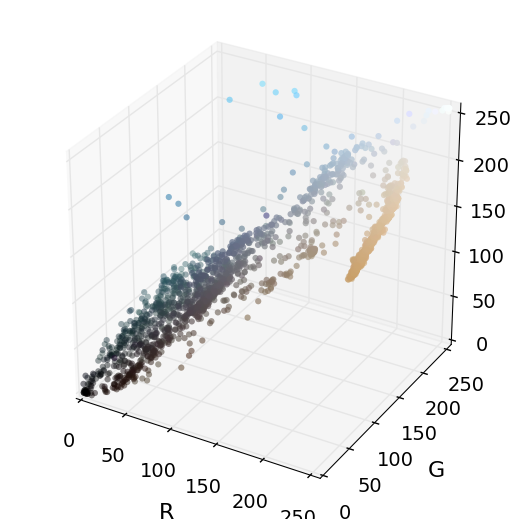

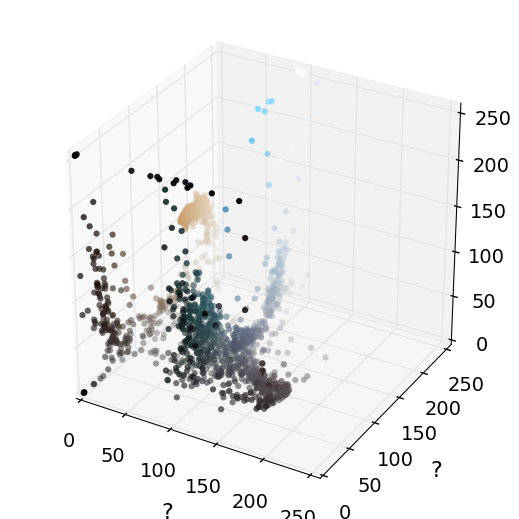

In [272]:
from mpl_toolkits.mplot3d import Axes3D

def plot3d(pixels, colors_rgb,
           axis_labels=list("???"), 
           axis_limits=[(0, 255), (0, 255), (0, 255)]):
    
    """Plot pixels in 3D."""
    # Create figure and 3D axes
    fig = plt.figure(figsize=(5,5))
    ax = Axes3D(fig)

    # Set axis limits
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])

    # Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)

    # Plot pixel values with colors given in colors_rgb
    ax.scatter(
        pixels[:, :, 0].ravel(),
        pixels[:, :, 1].ravel(),
        pixels[:, :, 2].ravel(),
        c=colors_rgb.reshape((-1, 3)), edgecolors='none')

    return ax  # return Axes3D object for further manipulation

# Read a color image
img = mpimg.imread("test-images/test4.jpg")
plt.figure(figsize=(2,2))
plt.axis('off')
plt.imshow(img)
plt.show()

# Select a small fraction of pixels to plot by subsampling it
scale = max(img.shape[0], img.shape[1], 64) / 64  # at most 64 rows and columns
img_small = cv2.resize(img, (np.int(img.shape[1] / scale), \
                       np.int(img.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)

# Convert subsampled image to desired color space(s)
img_small_RGB = cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)  # OpenCV uses BGR, matplotlib likes RGB
img_small_CONVERSION = cv2.cvtColor(img_small, cv2.COLOR_BGR2HLS)
colors_rgb = img_small_RGB / 255.  # scaled to [0, 1], only for color plotting

# Plot and show
plot3d(img_small_RGB, colors_rgb, axis_labels=list('RGB'))
plot3d(img_small_CONVERSION, colors_rgb)

# plt.imshow(img)
plt.show();

### Explore HOG

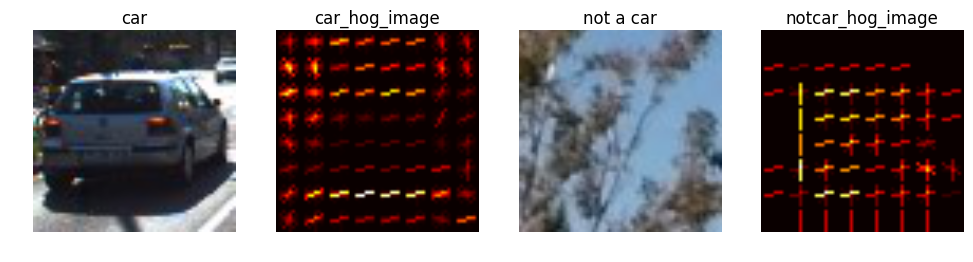

In [367]:
# tweak these parameters and see how the results change.
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 8
hog_channel = 1 # Can be 0, 1, 2, or "ALL"

randint = np.random.randint(0,100)
car_list = mpimg.imread(cars[randint])
notcar_list = mpimg.imread(notcars[randint])

car_feats, car_hog_image = single_img_features(car_list, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, \
                                               orient=orient, color_space=colorspace, hog_channel=hog_channel)
notcar_feats, notcar_hog_image = single_img_features(notcar_list, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, \
                                                     orient=orient, color_space=colorspace, hog_channel=hog_channel)

images = [car, car_hog_image, notcar, notcar_hog_image]
titles = ['car','car_hog_image','not a car','notcar_hog_image'] 

fig = plt.figure(figsize=(12,3))
visualize(fig, 1, 4, images, titles)

Improvements
* implement Information Gain so we can narrow down our feature vector and be smart about selecting our features
* add more pictures

### Test Model parameters

In [273]:
print('Training/testing on {} car images and {} non-car images'.format(len(cars), len(notcars)))

# Reduce the sample size because HOG features are slow to compute
# The quiz evaluator times out after 13s of CPU time
# sample_size = len(cars)
# cars = cars[0:sample_size]
# notcars = notcars[0:sample_size]

### TODO: Tweak these parameters and see how the results change.
colorspace = 'HLS' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 1 # Can be 0, 1, 2, or "ALL"

t=time.time()
car_features = extract_features(cars, color_space=colorspace, orient=orient,
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                        hog_channel=hog_channel)
notcar_features = extract_features(notcars, color_space=colorspace, orient=orient,
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)
X.shape
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC
svc = SVC(C=10, gamma=0.0001)
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = len(y_test)

from sklearn.utils import shuffle
X_test, y_test = shuffle(X_test, y_test)

# print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
# print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

# grid = {'kernel':['rbf'], 'C':[1,10,100,1000], 'gamma':[1,10,100,1000]}
# param_grid = ParameterGrid(grid)
# list(param_grid)

# grid = [{'kernel': ['linear']}, {'kernel': ['rbf'], 'gamma': [1, 10]}]
# list(ParameterGrid(grid))

# parameters = [{'C':[1,10,100,1000], 'gamma':[0.001, 0.0001], 'kernel':['rbf']}]

# svr = svm.SVC()
# clf = GridSearchCV(svr, parameters)
# clf.fit(X_train, y_train)

# clf.best_estimator_
# clf.score(X_test, y_test)

Training on 1196 car images and 1125 non-car images
12.29 Seconds to extract HOG features...


(2321, 4932)

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 4932


SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.0001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

4.87 Seconds to train SVC...
Test Accuracy of SVC =  0.9978
0.00901 Seconds to predict 465 labels with SVC


### Create Model

In [317]:
def model():

    # tweak these parameters and see how the results change.
    colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"    
    
    # extract feature vectors
    t = time.time()
    car_features = extract_features(cars, color_space=colorspace, orient=orient,
                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                            hog_channel=hog_channel)
    notcar_features = extract_features(notcars, color_space=colorspace, orient=orient,
                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                            hog_channel=hog_channel)
    extract_time = time.time() - t
    
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)
    print('{:2.2f}s to create X shape {}'.format(extract_time, X.shape))
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
    
    X_train, X_test, y_train, y_test = [],[],[],[]
    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.3)
    
    # count the number of tests subjects
    num_car = len([x for x in y_test if x==1.0])
    num_not_car = len([x for x in y_test if x==0.0])
    print('Test set: cars = {} and non-cars = {}'.format(num_car,num_not_car))
    
    # fit a RBF SVM
    t = time.time()
    svm = SVC(C=10, gamma=0.0001)
    svm.fit(X_train, y_train)
    rbf_time = time.time() - t
    
    # fit a Linear SVM
    t = time.time()
    svm_lin = LinearSVC(C=10)
    svm_lin.fit(X_train, y_train)
    lin_time = time.time() - t
    
    print('RBG SVM model score = {:2.5f} and time {:2.2f}'.format(svm.score(X_test, y_test), rbf_time))
    print('Linear SVM model score = {:2.5f} and time {:2.2f}'.format(svm_lin.score(X_test, y_test), lin_time))
    print('Done!')  
    
    return X_scaler, svm

X_scaler, model = model()

10.51s to create X shape (2321, 8460)
Test set: cars = 352 and non-cars = 345
RBG SVM model score = 0.99713 and time 7.88
Linear SVM model score = 0.99570 and time 0.52
Done!


Model improvements
* implement Keras CNN model
* utilize tensorboard and graphically display what's going on with a NN

Make sure your images are scaled correctly
The training dataset provided for this project ( vehicle and non-vehicle images) are in the .png format. Somewhat confusingly, matplotlib image will read these in on a scale of 0 to 1, but cv2.imread() will scale them from 0 to 255. Be sure if you are switching between cv2.imread() and matplotlib image for reading images that you scale them appropriately! Otherwise your feature vectors can get screwed up.

To add to the confusion, matplotlib image will read .jpg images in on a scale of 0 to 255 so if you are testing your pipeline on .jpg images remember to scale them accordingly. And if you take an image that is scaled from 0 to 1 and change color spaces using cv2.cvtColor() you'll get back an image scaled from 0 to 255. So just be sure to be consistent between your training data features and inference features!

### Sliding Window Tests

(2764800,)

(2764800, 1)

C:\Program Files\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


StandardScaler(copy=True, with_mean=True, with_std=True)

C:\Program Files\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


(2764800,)

(array([ 780489.,  445598.,  461911.,  288969.,  184382.,  249796.,
         171965.,  151063.,   17786.,   12841.]),
 array([-1.21146209, -0.78246382, -0.35346556,  0.0755327 ,  0.50453097,
         0.93352923,  1.3625275 ,  1.79152576,  2.22052402,  2.64952229,
         3.07852055]),
 <a list of 10 Patch objects>)

orig_shape  (720, 1280)


(720, 1280, 3)

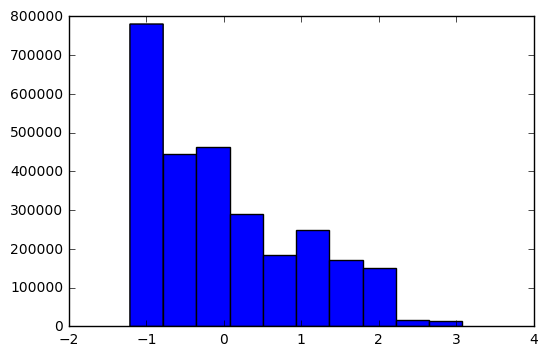

In [364]:
test_images = glob.glob('test-images/*.jpg')

img = mpimg.imread(test_images[0])
orig_shape = img.shape
img = img.ravel()
img.shape
img = img.reshape(-1,1)
img.shape

X_scaler.fit(img)
img = X_scaler.transform(img)
img = np.squeeze(img)
img.shape

plt.hist(img)

print('orig_shape ', orig_shape[0:2])
img_new = np.reshape(tmp, (720,1280, 3))
img_new.shape

# only select positive

In [365]:
test_images = glob.glob('test-images/*.jpg')

images = []
titles = []
y_start_stop = [None, None]
xy_overlap = (0.5, 0.5)
xy_window = (128,128)
color_space = 'YUV'
spatial_size = (32,32) # resize img to this, and then extract color pixels
hist_bins = 32
hog_channel = 'ALL'
X_scaler = X_scaler

for image in test_images:
    time_1 = time.time()
    img = mpimg.imread(image)
    draw_img = np.copy(img)
    
    # pass in an image and return a list of windows corner vertices ((win_corner_1),(win_corner_2))
    windows_to_test = slide_window(img, x_start_stop=[None, None], y_start_stop=y_start_stop,
                                   xy_window=xy_window, xy_overlap=xy_overlap)
    
#     # now we have a list of all the windows that we are going to test if they have a car in them
#     # 'search_windows' will take each window and test it
#     # if this func predicts that the `window_to_test` is a car, it will return that window in a list
    hot_windows = search_windows(img, windows_to_test, model, X_scaler, color_space=color_space, 
                                 spatial_size=spatial_size, hist_bins=hist_bins, hog_channel=hog_channel)
    
    hot_img = draw_boxes(draw_img, hot_windows, color=(50,50,255), thick=6)
    images.append(hot_img)
#     titles.append('')
    print('{:2.2f}s to process {} with {} windows'.format(time.time()-time_1, image, len(windows_to_test)))
    
fig = plt.figure(figsize=(12,18))
visualize(fig, 5, 2, images, titles)  

ValueError: setting an array element with a sequence.

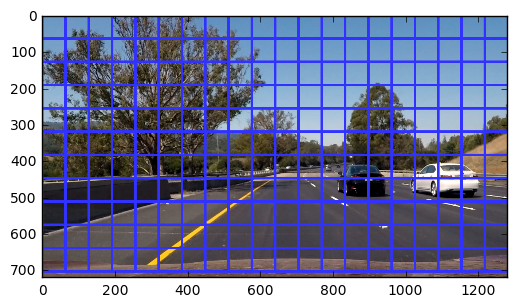

In [328]:
plt.imshow(draw_boxes(draw_img, windows_to_test, color=(50,50,255), thick=6))